# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x17E8B139A10>, 5)


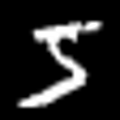

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [5]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [6]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [8]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################

##### MY INITIAL APPROACH #####

# # Initialize variables to accumulate the sum of pixel values and pixel value squared
# sum_channel = 0.0
# sum_squared_channel = 0.0
# total_images = len(ims_train)

# # Iterate through the dataset to calculate the mean
# for image in ims_train:
#     sum_channel += image.sum()

# # Calculate the mean
# mu = sum_channel / (total_images * 28 * 28)  # MNIST images are 28x28 pixels

# # Initialize variables to accumulate the sum of squared pixel values
# # This will be used to calculate the standard deviation
# for image in ims_train:
#     sum_squared_channel += (image - mu).pow(2).sum()

# # Calculate the standard deviation
# std = (sum_squared_channel / (total_images * 28 * 28)).sqrt()

##### PYTORCH SHORTHAND #####:
mu = torch.mean(ims_train)
std = ims_train.std()

print(f"Mean (mu): {mu}")                   # Should be around 0.1307 according to MNIST
print(f"Standard Deviation (std): {std}")   # Should be around 0.3081 according to MNIST

Mean (mu): 0.13066047430038452
Standard Deviation (std): 0.30810782313346863


We normalize the data as below.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [10]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [11]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [12]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [13]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####

        # Input layer
        layers.append(nn.Linear(nInput, nHidden))
        layers.append(act_fn)
        
        # Hidden layers
        for _ in range(nLayer - 1):  # Subtract 1 for the input layer
            layers.append(nn.Linear(nHidden, nHidden))
            layers.append(act_fn)
        
        # Output layer
        layers.append(nn.Linear(nHidden, nOutput))
        
        self.model = nn.Sequential(*layers)
        
        
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [14]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [15]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [16]:
def test(model, dl_test, device='cuda:0'):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [17]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cuda:0'):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####

        # Forward pass
        output = model(data)

        # Calculate the cross-entropy loss
        loss = F.cross_entropy(output, target)

        # Backpropagate gradients
        loss.backward()

        # Take a gradient step
        optimizer.step()
      
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [18]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [19]:
# Sanity check for GPU
if torch.cuda.is_available():
    # Number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()

    print(f"Number of CUDA devices available: {num_cuda_devices}")

    # Name of the current CUDA device (you can specify a device number)
    current_device_name = torch.cuda.get_device_name(0)  # 0 is the default device
    print(f"Current CUDA device name: {current_device_name}")

else:
    print("CUDA is not available on this system.")

Number of CUDA devices available: 1
Current CUDA device name: NVIDIA GeForce RTX 4090


In [20]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308894
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.646103
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.359835
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.349071
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.345687
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.165195
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.514889
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.231281
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.240698
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.369908

Train set: Average loss: 0.1431, Accuracy: 52085/60000 (86.8%)


Test set: Average loss: 0.2591, Accuracy: 9245/10000 (92.450%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.276608
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.224417
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.294205
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.356881
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.273001
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.196116
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.197861
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [20]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 8
nHidden = 64
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 15
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311191
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.130693
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.453733
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.869258
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.362122
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.325058
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.278667
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.396176
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.262382
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.333349

Train set: Average loss: 0.2166, Accuracy: 48735/60000 (81.2%)


Test set: Average loss: 0.2336, Accuracy: 9308/10000 (93.080%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.072639
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.104234
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.265248
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.314339
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.147882
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.404202
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.105415
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [21]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        # Define the fully connected (linear) layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Define max-pooling and dropout layers
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply the first convolutional layer and ReLU
        x = self.conv1(x)
        x = F.relu(x)
        
        # Apply the second convolutional layer and ReLU
        x = self.conv2(x)
        x = F.relu(x)
        
        # Apply max-pooling
        x = self.maxpool(x)

        # Apply the first dropout
        x = self.dropout1(x)
        
        # Flatten the output before passing it to the fully connected layers
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer, ReLU, and dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Apply the second fully connected layer (output layer)
        x = self.fc2(x)
        
        return x


In [22]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [23]:
optimizer = optim.Adam(cnn.parameters())

In [24]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303755
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.239068
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.228386
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.026319
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.273894
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.066575
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.101551
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.216429
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.041095
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.033860

Train set: Average loss: 0.0196, Accuracy: 56213/60000 (93.7%)


Test set: Average loss: 0.0505, Accuracy: 9833/10000 (98.330%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.058980
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.028132
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.030548
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.016999
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.053725
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.052178
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.037109
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: It should be around 10%, since it is effectively the same as randomly guessing.


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [25]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [26]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [27]:
ims_train.shape

torch.Size([50000, 32, 32, 3])

In [28]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################

##### MY INITIAL APPROACH #####
# # Initialize variables to accumulate the sum of pixel values and pixel value squared for each channel
# sum_channel = [0.0, 0.0, 0.0]
# sum_squared_channel = [0.0, 0.0, 0.0]
# total_images = ims_train.size(0)

# # Calculate the mean for each channel
# for i in range(ims_train.size(0)):
#     for channel in range(3):
#         image_tensor = ims_train[i, :, :, channel]
#         sum_channel[channel] += image_tensor.sum()

# mu = [sum_channel[channel] / (total_images * 32 * 32) for channel in range(3)]

# # Initialize variables to accumulate the sum of squared pixel values
# # This will be used to calculate the standard deviation for each channel
# for i in range(ims_train.size(0)):
#     for channel in range(3):
#         image_tensor = ims_train[i, :, :, channel]
#         sum_squared_channel[channel] += (image_tensor - mu[channel]).pow(2).sum()

# # Calculate the standard deviation for each channel
# std = [(sum_squared_channel[channel] / (total_images * 32 * 32)).sqrt() for channel in range(3)]

##### PYTORCH SHORTHAND #####
mu = torch.mean(ims_train, dim=(0,1,2))
std = ims_train.std((0,1,2))

print(f"Mean (mu) for each channel: {mu}")
print(f"Standard Deviation (std) for each channel: {std}")

Mean (mu) for each channel: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation (std) for each channel: tensor([0.2470, 0.2435, 0.2616])


For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [29]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop a 32x32 portion of the image
    transforms.RandomHorizontalFlip(p=0.4),  # Randomly flip the image horizontally with a 40% probability
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=mu, std=std)  # Normalize using the calculated mean and standard deviation
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=mu, std=std)  # Normalize using the calculated mean and standard deviation
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

# Create data loaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [30]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [31]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [32]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        # Define the fully connected (linear) layers
        self.fc1 = nn.Linear(12544, 128) # This time 14 x 14 image at this point instead of 12 x 12
        self.fc2 = nn.Linear(128, 10)
        
        # Define max-pooling and dropout layers
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply the first convolutional layer and ReLU
        x = self.conv1(x)
        x = F.relu(x)
        
        # Apply the second convolutional layer and ReLU
        x = self.conv2(x)
        x = F.relu(x)
        
        # Apply max-pooling
        x = self.maxpool(x)

        # Apply the first dropout
        x = self.dropout1(x)
        
        # Flatten the output before passing it to the fully connected layers
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer, ReLU, and dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Apply the second fully connected layer (output layer)
        x = self.fc2(x)
        
        return x

In [33]:
CNN_CIFAR()(torch.randn(1,3,32,32)).shape

torch.Size([1, 10])

Let's try again

In [34]:
cnn = CNN_CIFAR()
optimizer = optim.SGD(cnn.parameters(), lr=0.10, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.319374
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.010824
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.008115
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.722520

Train set: Average loss: 1.8642, Accuracy: 12801/50000 (25.6%)


Test set: Average loss: 1.7030, Accuracy: 3758/10000 (37.580%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.869960
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.882396
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.804183
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.763833

Train set: Average loss: 1.7508, Accuracy: 16681/50000 (33.4%)


Test set: Average loss: 1.5515, Accuracy: 4290/10000 (42.900%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.743957
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.711377
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.940352
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.788715

Train set: Average loss: 1.8223, Accuracy: 17422/50000 (34.8%)


Test set: Average loss: 1.4922, Accuracy: 4504/10000 (45.040%)

Train Epoch: 4 [0/50000 (

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
print(cnn)

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [ ]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################


In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %